In [112]:
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
import math, re, os
import numpy as np
import tensorflow as tf

In [113]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
y=df.pop('label')
y = np.array(y)

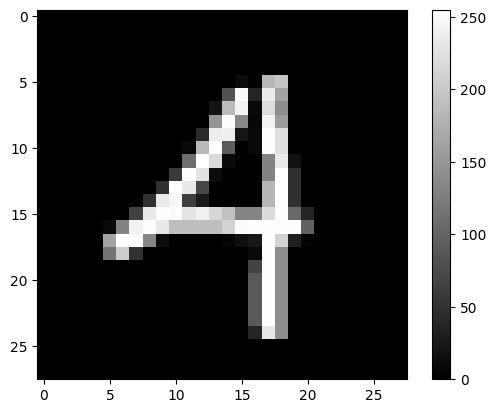

In [114]:
X = df.values
rand = X[np.random.randint(0,X.shape[0])]
numpy_array = np.reshape(rand,(28,28))
plt.imshow(numpy_array, cmap='gray')
plt.colorbar()
plt.show()

In [115]:
from sklearn.model_selection import train_test_split
X=torch.tensor(X,dtype=torch.float32)
y=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# import numpy as np
# classi=RandomForestClassifier(max_depth=11)
# classi.fit(X_train,y_train)
# with np.warnings.catch_warnings():
#     np.warnings.filterwarnings('ignore', category=FutureWarning)

#     # Your code for making predictions and calculating accuracy

#     y_test_pred = classi.predict(X_test)
#     y_train_pred = classi.predict(X_train)

#     # Calculate accuracy
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     train_accuracy = accuracy_score(y_train, y_train_pred)

    
#     print(f'Train Accuracy: {train_accuracy:.4f}')
#     print(f'Validation Accuracy: {test_accuracy:.4f}')
    
# ans=pd.DataFrame({'ImageId': range(1,len(test)+1),'Label':classi.predict(test)}).set_index('ImageId')
# ans.to_csv('answer.csv')

In [117]:
import torch.nn as nn
import torchvision.transforms as transforms
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0.5),
            nn.Conv2d(256, 128, kernel_size=5, stride=2, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            #nn.Dropout(0.5),
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=1),
            nn.Dropout(0.5),
        )      
        self.fc_block = nn.Sequential(
            nn.Linear(128,1028),
            nn.Linear(1028,512),
            nn.Linear(512,10),
        )
    def forward(self, x):
        x = self.ConvBlock1(x)
        x = x.view(x.shape[0], -1)
        logits = self.fc_block(x)
        return logits
            

In [118]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
data_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])
train_dataset = TensorDataset(X_train, y_train)
train_dataset.transforms = data_transforms
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataset.transforms = data_transforms
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [119]:
def Train(train_loader,test_loader,model,device,loss_fn,optimizer):
    total_loss = 0.0
    correct_predictions = 0
    for (X,y) in train_loader:
        X = X.view(-1, 1, 28, 28)
        X=X.to(device)
        y=y.to(device)
        logits=model(X)
        loss=loss_fn(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == y).sum().item()
        X=X.to('cpu')
        y=y.to('cpu')
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct_predictions / len(train_loader.dataset) * 100
    print(f" Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.view(-1, 1, 28, 28)
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Validation accuracy: {accuracy:.2f}%')


In [120]:
model=NeuralNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs=30
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
for epoch_num in range(epochs):
    print(f"Epoch {epoch_num + 1}/{epochs},",end='')
    Train(train_loader,test_loader, model, device, loss_fn, optimizer)
    


Epoch 1/30, Loss: 0.0141, Accuracy: 75.99%
Validation accuracy: 84.13%
Epoch 2/30, Loss: 0.0078, Accuracy: 85.01%
Validation accuracy: 85.20%
Epoch 3/30, Loss: 0.0080, Accuracy: 84.94%
Validation accuracy: 85.65%
Epoch 4/30, Loss: 0.0080, Accuracy: 84.51%
Validation accuracy: 85.63%
Epoch 5/30, Loss: 0.0076, Accuracy: 85.55%
Validation accuracy: 83.86%
Epoch 6/30, Loss: 0.0072, Accuracy: 86.57%
Validation accuracy: 86.93%
Epoch 7/30, Loss: 0.0069, Accuracy: 86.88%
Validation accuracy: 86.63%
Epoch 8/30, Loss: 0.0067, Accuracy: 87.34%
Validation accuracy: 86.24%
Epoch 9/30, Loss: 0.0067, Accuracy: 87.51%
Validation accuracy: 87.71%
Epoch 10/30, Loss: 0.0066, Accuracy: 87.65%
Validation accuracy: 86.99%
Epoch 11/30, Loss: 0.0066, Accuracy: 87.55%
Validation accuracy: 87.82%
Epoch 12/30, Loss: 0.0064, Accuracy: 88.03%
Validation accuracy: 86.81%
Epoch 13/30, Loss: 0.0066, Accuracy: 87.54%
Validation accuracy: 87.99%
Epoch 14/30, Loss: 0.0062, Accuracy: 88.61%
Validation accuracy: 86.74%
E